# Import thư viện cần thiết

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.datasets import load_digits, fetch_openml
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import resample

# Cấu hình hiển thị
plt.style.use('ggplot')

# Setup dataset

In [2]:
def get_dataset(size_type):
    """
    Hàm tải dữ liệu. Sử dụng OpenML để tránh lỗi HTTP 403 và đảm bảo dữ liệu thuần số.
    """
    if size_type == 'small':
        print("\n[Data] Đang tải Digits (Small: D <= 100)...")
        # Dữ liệu tích hợp sẵn, không cần mạng
        data = load_digits()
        X = data.data
        y = data.target
        
    elif size_type == 'medium':
        print("\n[Data] Đang tải MNIST (Medium: 100 < D < 10000)...")
        # MNIST Original từ OpenML (D=784)
        # as_frame=False để trả về numpy array ngay lập tức
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
        
        # Ép kiểu sang float để tránh lỗi type object
        X = X.astype(np.float32)
        X = X / 255.0
        
        # Lấy mẫu 2000 dòng để chạy nhanh
        X, y = resample(X, y, n_samples=2000, random_state=42)
        
    elif size_type == 'large':
        print("\n[Data] Đang tải Arcene (Large: D >= 10000)...")
        # Sử dụng bộ dữ liệu ARCENE (ID 1458)
        # Đây là bộ dữ liệu chuẩn NIPS 2003: N=200 (khi gộp train/valid), D=10,000
        # Dữ liệu này sạch và chắc chắn là số.
        try:
            X, y = fetch_openml(data_id=1458, return_X_y=True, as_frame=False, parser='auto')
        except Exception:
            print("Fallback sang bộ Dexter (ID 4135)...")
            # Fallback: Dexter (D=20,000)
            X, y = fetch_openml(data_id=4135, return_X_y=True, as_frame=False, parser='auto')

        # QUAN TRỌNG: Ép kiểu dữ liệu về float để đảm bảo không còn chuỗi (str)
        # np.nan_to_num sẽ thay thế các giá trị NaN (nếu có) bằng 0
        try:
            if hasattr(X, "toarray"): # Nếu là sparse matrix
                X = X.toarray()
            X = X.astype(np.float32)
            X = np.nan_to_num(X)
        except ValueError as e:
            print(f"Cảnh báo dữ liệu: {e}. Đang cố gắng sửa...")
            # Nếu vẫn lỗi, thử clean lần cuối
            X = np.nan_to_num(pd.DataFrame(X).apply(pd.to_numeric, errors='coerce').fillna(0).values)

        # Dataset này số dòng (N) ít nên không cần resample, chạy full luôn
        # Chuẩn hóa dữ liệu
        max_val = np.abs(X).max()
        if max_val > 0:
            X = X / max_val

    print(f" -> Kích thước dữ liệu: {X.shape} (N={X.shape[0]}, D={X.shape[1]})")
    return X, y

# Metrics

In [3]:
def compute_reconstruction_error(X_orig, X_proj):
    """
    Tính lỗi sai biệt khoảng cách (Distortion).
    Theo paper: kiểm tra xem khoảng cách đôi một có được bảo toàn không.
    """
    # Để tiết kiệm RAM và CPU, chỉ tính trên 500 mẫu ngẫu nhiên
    n_samples = min(X_orig.shape[0], 500)
    indices = np.random.choice(X_orig.shape[0], n_samples, replace=False)
    
    # Lấy dữ liệu mẫu (hỗ trợ cả Sparse Matrix cho RCV1)
    X_sample_orig = X_orig[indices]
    X_sample_proj = X_proj[indices]
    
    # Tính khoảng cách
    d_orig = euclidean_distances(X_sample_orig)
    d_proj = euclidean_distances(X_sample_proj)
    
    # Mask để tránh chia cho 0 (đường chéo chính)
    mask = d_orig > 1e-6
    
    # Tính tỷ lệ lỗi: |d_proj / d_orig - 1|
    # Paper Equation (9): (1-eps) ||u-v||^2 <= ||Pv - Pu||^2 <= (1+eps) ||u-v||^2
    distortion = np.abs((d_proj[mask] / d_orig[mask]) - 1)
    
    return np.mean(distortion)

# BENCHMARK ENGINE

In [4]:
def run_benchmark(X, dataset_name):
    n_samples, n_features = X.shape
    
    # Các mức n_components (k) để test
    # Chọn k nhỏ hơn D gốc
    k_list = [10, 50, 100, 200, 500]
    k_list = [k for k in k_list if k < n_features]
    
    # Định nghĩa 3 phương pháp theo Paper
    # 1. Gaussian (Baseline) [cite: 13]
    # 2. Sparse (Achlioptas): density = 1/3 (s=3) 
    # 3. Very Sparse (Ping Li): density = 1/sqrt(D) (s=sqrt(D)) 
    
    density_very_sparse = 1 / np.sqrt(n_features)
    
    methods = {
        "Gaussian RP": (GaussianRandomProjection, {}),
        "Sparse RP (s=3)": (SparseRandomProjection, {'density': 1/3}),
        f"Very Sparse (s=√{n_features})": (SparseRandomProjection, {'density': density_very_sparse})
    }
    
    results = []

    print(f"Bắt đầu Benchmark bộ: {dataset_name}...")
    
    for k in k_list:
        for method_name, (ModelClass, params) in methods.items():
            # Khởi tạo model
            transformer = ModelClass(n_components=k, random_state=42, **params)
            
            # Đo thời gian Fit + Transform
            start_time = time.time()
            X_new = transformer.fit_transform(X)
            run_time = time.time() - start_time
            
            # Đo lỗi tái tạo
            error = compute_reconstruction_error(X, X_new)
            
            # Lưu kết quả
            results.append({
                "Dataset": dataset_name,
                "Components (k)": k,
                "Method": method_name,
                "Time (s)": run_time,
                "Reconstruction Error": error,
                "Density Used": params.get('density', 1.0)
            })
            
    return pd.DataFrame(results)

# VISUALIZATION

In [5]:
def plot_benchmark(df, dataset_name, ax_time, ax_error):
    data = df[df["Dataset"] == dataset_name]
    methods = data["Method"].unique()
    
    for method in methods:
        subset = data[data["Method"] == method]
        # Vẽ thời gian
        ax_time.plot(subset["Components (k)"], subset["Time (s)"], marker='o', label=method)
        # Vẽ lỗi
        ax_error.plot(subset["Components (k)"], subset["Reconstruction Error"], marker='s', label=method)
    
    ax_time.set_title(f"Processing Time - {dataset_name}")
    ax_time.set_xlabel("k")
    ax_time.set_ylabel("Seconds")
    ax_time.legend()
    ax_time.grid(True)
    
    ax_error.set_title(f"Reconstruction Error - {dataset_name}")
    ax_error.set_xlabel("k")
    ax_error.set_ylabel("Mean Relative Error")
    ax_error.legend()
    ax_error.grid(True)

# Main


[Data] Đang tải Digits (Small: D <= 100)...
 -> Kích thước dữ liệu: (1797, 64) (N=1797, D=64)
Bắt đầu Benchmark bộ: SMALL (D=64)...

[Data] Đang tải MNIST (Medium: 100 < D < 10000)...
 -> Kích thước dữ liệu: (2000, 784) (N=2000, D=784)
Bắt đầu Benchmark bộ: MEDIUM (D=784)...

[Data] Đang tải Arcene (Large: D >= 10000)...
 -> Kích thước dữ liệu: (200, 10000) (N=200, D=10000)
Bắt đầu Benchmark bộ: LARGE (D=10000)...

[Result] Đang vẽ biểu đồ so sánh...


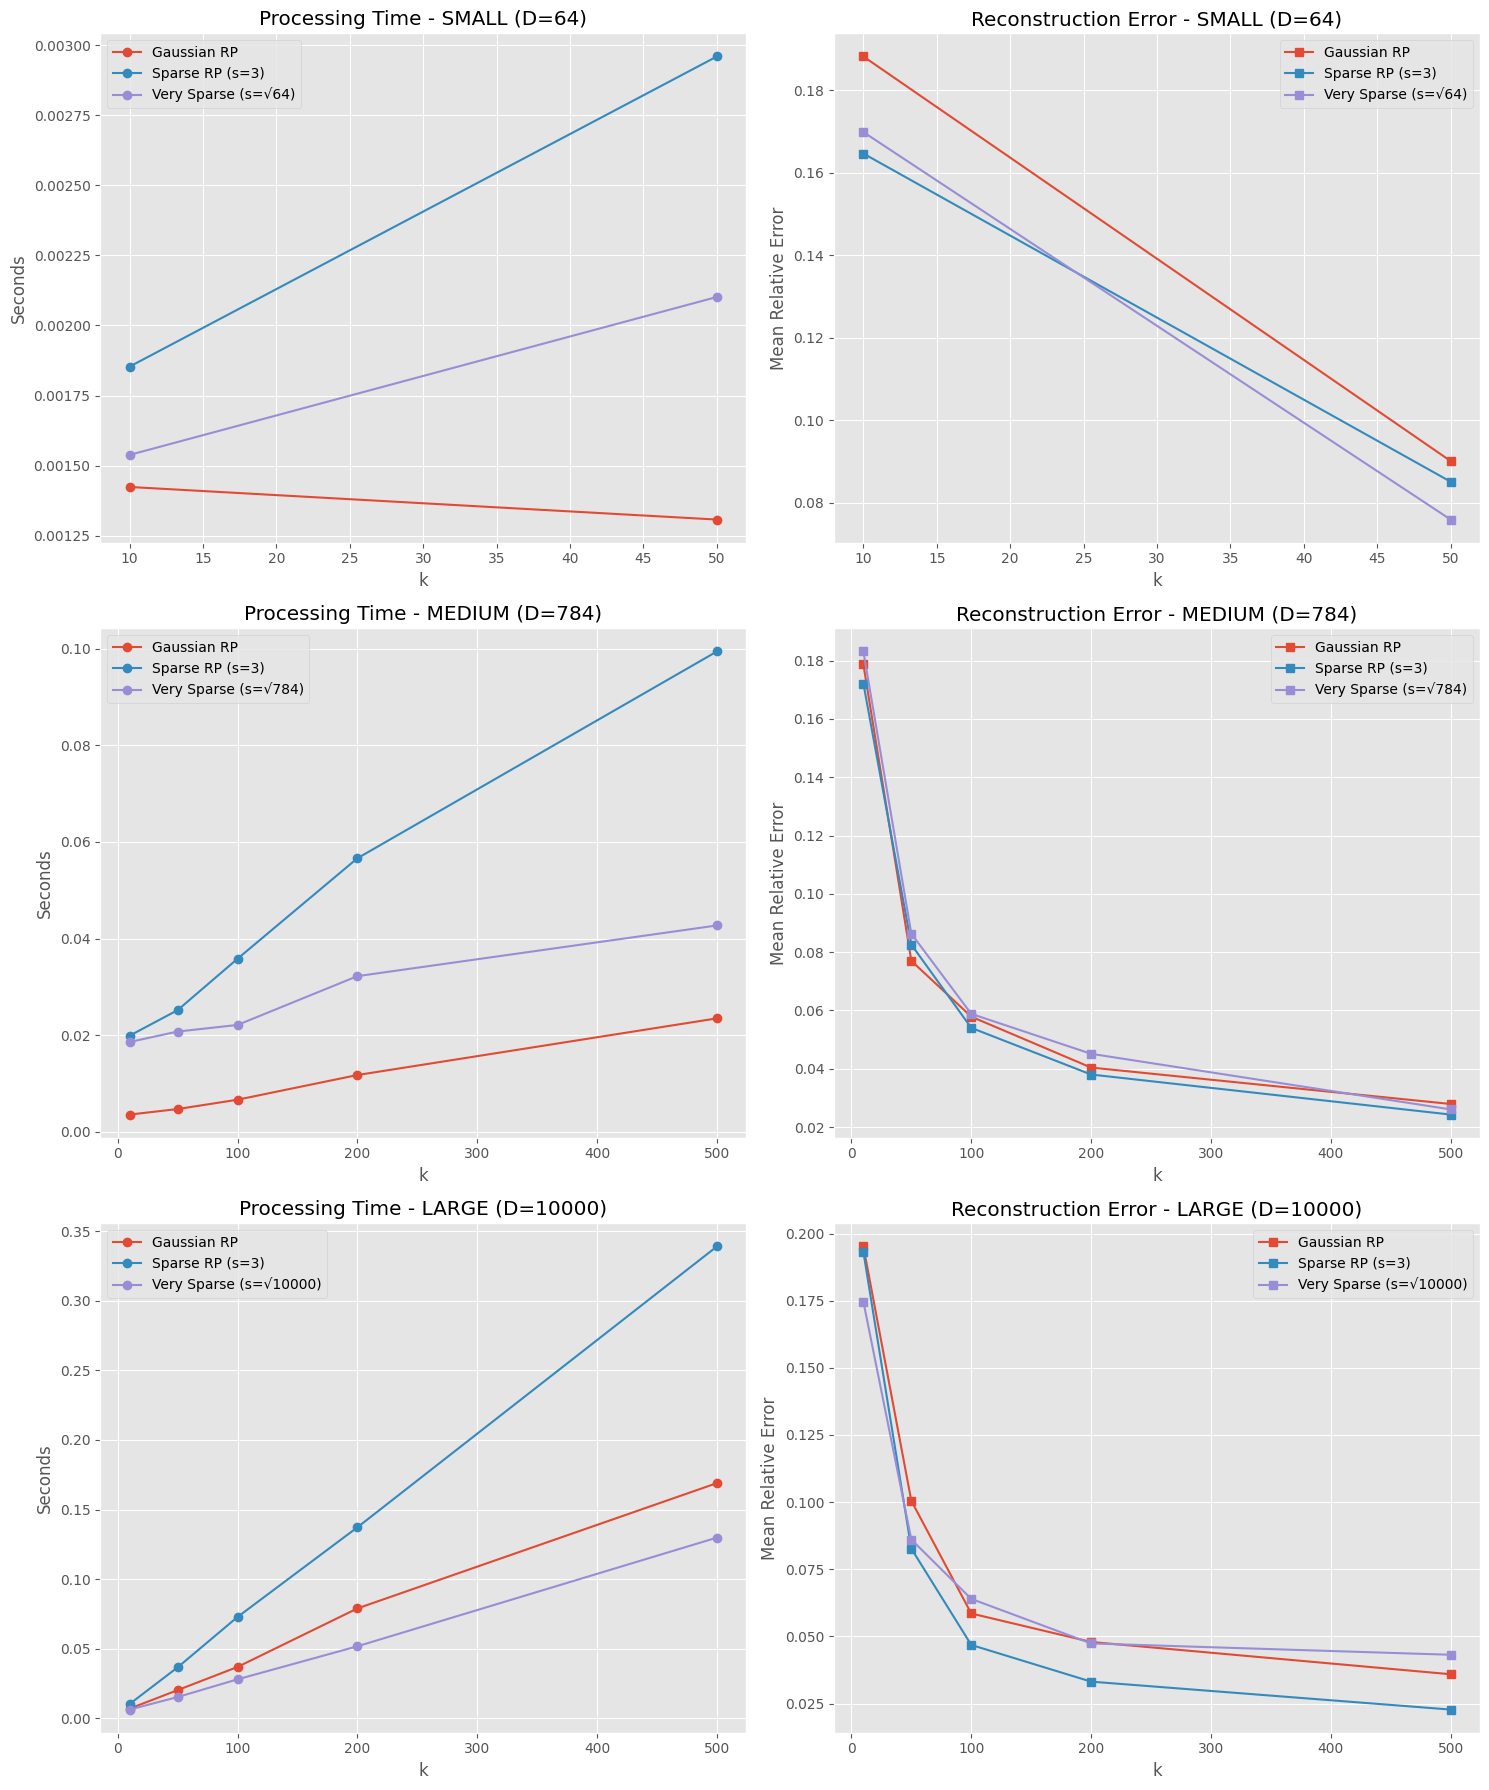


--- Bảng kết quả chi tiết (Top 10 dòng) ---
          Dataset  Components (k)                Method  Time (s)  \
0    SMALL (D=64)              10           Gaussian RP  0.001424   
1    SMALL (D=64)              10       Sparse RP (s=3)  0.001853   
2    SMALL (D=64)              10   Very Sparse (s=√64)  0.001538   
3    SMALL (D=64)              50           Gaussian RP  0.001307   
4    SMALL (D=64)              50       Sparse RP (s=3)  0.002960   
5    SMALL (D=64)              50   Very Sparse (s=√64)  0.002102   
0  MEDIUM (D=784)              10           Gaussian RP  0.003549   
1  MEDIUM (D=784)              10       Sparse RP (s=3)  0.019883   
2  MEDIUM (D=784)              10  Very Sparse (s=√784)  0.018576   
3  MEDIUM (D=784)              50           Gaussian RP  0.004689   

   Reconstruction Error  Density Used  
0              0.188168      1.000000  
1              0.164641      0.333333  
2              0.169845      0.125000  
3              0.090111      1.0000

In [6]:
if __name__ == "__main__":
    # 1. Chọn Dataset
    datasets_to_run = ['small', 'medium', 'large'] 
    all_results = pd.DataFrame()

    # 2. Chạy vòng lặp
    for size in datasets_to_run:
        X, y = get_dataset(size)
        name = f"{size.upper()} (D={X.shape[1]})"
        df_res = run_benchmark(X, name)
        all_results = pd.concat([all_results, df_res])

    # 3. Vẽ biểu đồ tổng hợp
    print("\n[Result] Đang vẽ biểu đồ so sánh...")
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    unique_datasets = all_results["Dataset"].unique()
    for i, ds_name in enumerate(unique_datasets):
        plot_benchmark(all_results, ds_name, axes[i][0], axes[i][1])
        
    plt.tight_layout()
    plt.show()
    
    # 4. In bảng kết quả mẫu
    print("\n--- Bảng kết quả chi tiết (Top 10 dòng) ---")
    print(all_results.head(10))